In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")

In [2]:
import json
import numpy as np
import proplot as pplt
import warnings
warnings.filterwarnings("ignore")

COLORS = []
colors = pplt.Cycle('ggplot')
for color in colors:
    COLORS.append(color['color'])
colors = pplt.Cycle('default')
for color in colors:
    COLORS.append(color['color'])

COLORS[0], COLORS[1] = COLORS[1], COLORS[0]

    
pplt.rc['figure.facecolor'] = 'white'

RESULT_DIR = "../../mpcd_result/"
DATA_DIR    = "../../mpcd/result_1106/"
FIGURE_DIR = "../../mpcd_figure/"

with open('plot_style.json', 'r') as f:
    format_params = json.load(f)
    
MOMENTS    = np.array([0.1, 0.08, 0.06, 0.04, 0.030, 0.024, 0.018, 0.012, 
                    0.006, 0.003, 0.001, 0.0008, 0.0006, 0.0004])

def format_ax(ax):
    ax.format(**format_params)
    ax.tick_params(top=True, right=True, bottom=True, left=True, which='both')
    ax.minorticks_on()

In [4]:
import matplotlib
from matplotlib.ticker import LogLocator
import sklearn.metrics as skm
from scipy.stats import pearsonr
from tensorflow.keras import backend as K

from cg_topo_solv.ml.cv_select import cv_select, pareto_frontier, closest_to_origin
from cg_topo_solv.ml.data import load_data
from cg_topo_solv.ml.vae import get_file_names, train_vae
from cg_topo_solv.plot.plot_graph import plot_graph

In [14]:
metrics, weight_files = cv_select()

baccs = metrics[:, 1]
r2s = metrics[:, 2]
f1s = metrics[:, 3]
kls = metrics[:, 0]


pareto_indices, pareto_front = pareto_frontier(1 - baccs, 1 - r2s, 1 - f1s, kls, limits=[0.1, 0.1, 0.1, np.inf])

best_point, best_idx = closest_to_origin(pareto_front)

print(weight_files[best_idx])

desc_gnn_cnn_20240816_8_val_decoder_acc_True_True_1.0_[1.0, 100.0, 100.0]_0.005_256.h5


In [5]:
(
    (x_train, y_train, c_train, l_train, graph_train),
    (x_valid, y_valid, c_valid, l_valid, graph_valid),
    (x_test, y_test, c_test, l_test, graph_test),
    NAMES,
    SCALER,
    SCALER_y,
    LE,
) = load_data(data_dir="../../data_ml/data_aug10.pickle", fold=0, if_validation=True, rerun=False)

has_nan = np.isnan(l_train).any()
has_inf = np.isinf(l_train).any()

print("l_train contains NaN values:", has_nan)
print("l_train contains inf values:", has_inf)
print(f"l_train shape: {l_train.shape}")

l_train contains NaN values: False
l_train contains inf values: False
l_train shape: (4290, 12)


In [7]:
K.clear_session()

LATENT_DIM = 8
DECODER = "cnn"
ENCODER = "desc_gnn"
MONITOR = "val_decoder_acc"
IF_REG = True
IF_CLS = True
LR = 0.005
BS = 256
rw = 100.0
cw = 100.0

weight_name, hist_name = get_file_names(ENCODER, DECODER, "20240816", 
                                        LATENT_DIM, MONITOR, 
                                        IF_REG, IF_CLS, 1.0, [1.0, rw, cw], LR, BS)

if_train = False

model, pickle_file = train_vae(ENCODER, DECODER, MONITOR,
                IF_REG, IF_CLS,
                x_train, x_valid,
                y_train, y_valid,
                c_train, c_valid,
                l_train, l_valid,
                1.0, [1.0, rw, cw],
                LR, BS,
                if_train, verbose=2, n_epoch=1000)

d_out, r_out, c_out = model.predict([[np.copy(x_test), np.copy(x_test)], np.copy(l_test)])
y_pred = SCALER_y.inverse_transform(r_out)
y_true = SCALER_y.inverse_transform(y_test)

desc_gnn_cnn_20240816_8_val_decoder_acc_True_True_1.0_[1.0, 100.0, 100.0]_0.005_256.h5 finished in 0.73 sec ...
43/43 [==============================] - 1s 27ms/step


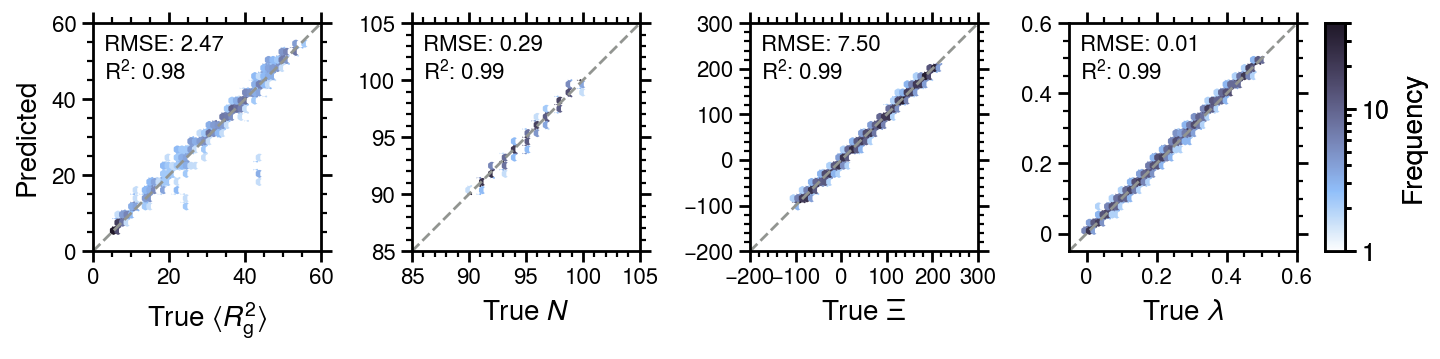

In [9]:
labels = [
    r"$\langle \mathit{R}_{\mathrm{g}}^2 \rangle$",
    r"$\mathit{N}$",
    r"$\mathit{\Xi}$",
    r"$\mathit{\lambda}$",
]

ticks = [
    [0, 20, 40, 60],
    [85, 90, 95, 100, 105],
    [-200, -100, 0, 100, 200, 300],
    [0.0, 0.2, 0.4, 0.6],
]
lims = [[0, 60], [85, 105], [-200, 300], [-0.05, 0.6]]

fig, ax = pplt.subplots(journal="nat2", refaspect=1, ncols=4, share=False)

for i in range(y_true.shape[1]):
    xin = y_true[:, i]
    yin = y_pred[:, i]

    rmse = np.sqrt(skm.mean_squared_error(xin, yin))
    r2 = skm.r2_score(xin, yin)
    pearson_r, _ = pearsonr(xin, yin)

    im = ax[i].hexbin(
                xin,
                yin,
                gridsize=50,
                norm=matplotlib.colors.LogNorm(),
                cmap="Dusk",
                extent=[lims[i][0], lims[i][1], lims[i][0], lims[i][1]],
                )

    ax[i].plot(lims[i], lims[i], "--", color="gray", linewidth=1)

    format_ax(ax[i])
    ax[i].format(
        xticks=ticks[i],
        yticks=ticks[i],
        xlim=lims[i],
        ylim=lims[i],
        xlabel="True " + labels[i],
        ylabel="Predicted" if i == 0 else None,
    )

    ax[i].text(
        0.05,
        0.95,
        f"RMSE: {rmse:.2f}\n$R^2$: {r2:.2f}",#\nPearson r: {pearson_r:.2f}",
        ha="left",
        va="top",
        transform=ax[i].transAxes,
        fontsize=8,
        bbox=dict(facecolor="none", alpha=0.8, edgecolor="none"),)

cb = fig.colorbar(
        im,
        ax=ax[3],
        label="Frequency",
        labelsize=10,
        extend="both",
        width=0.1,
    )

log_locator = LogLocator(base=10, subs="auto", numticks=10)

cb.ax.yaxis.set_minor_locator(log_locator)
cb.ax.tick_params(axis="both", which="both", width=1.0)
cb.outline.set_linewidth(1.0) 

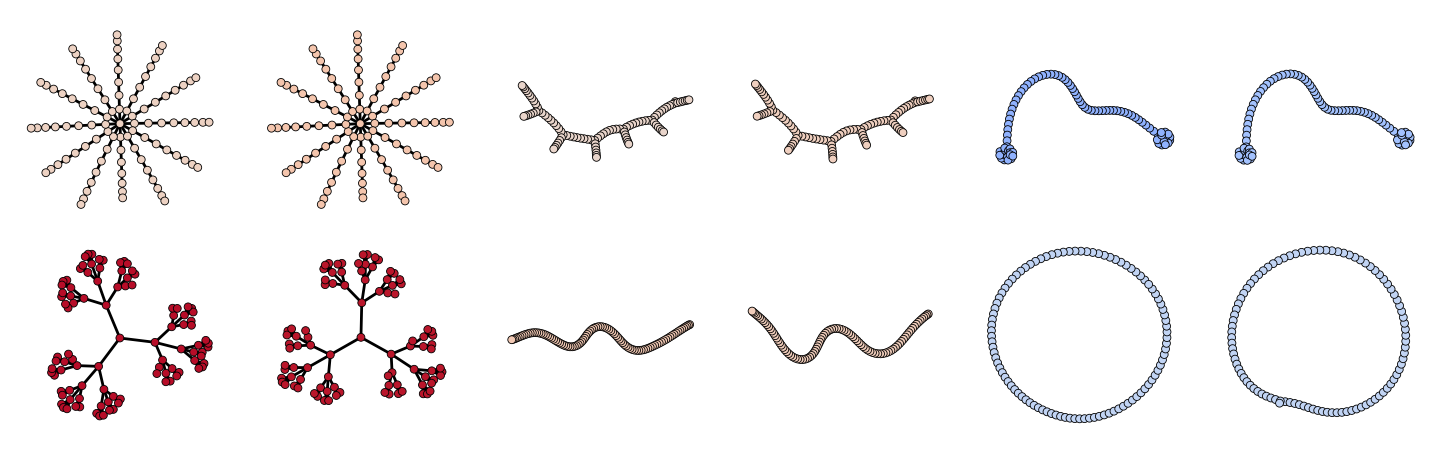

In [53]:
fig, ax = pplt.subplots(ncols=6, nrows=2, journal="nat2", refaspect=1, hspace=0.0)

for i, idx in enumerate([12,   0,  336,  52, 125, 680]):#[0, 26, 52, 135, 666, 888]):
    G_true = graph_test[idx]
    G_pred = graph_anneal_break_largest_circle(d_out[idx])
    lam_true = y_true[idx, -1]
    lam_pred = y_pred[idx, -1]
    
    plot_graph(G_true, ax[i*2], lam_true, node_size=8, lw=0.3)
    plot_graph(G_pred, ax[i*2+1], lam_pred, node_size=8, lw=0.3)